# Import Library

In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
print(tf.__version__)

SEED = 1234
NUM_FORECASTS = 15 #7 days

2.5.0


# Load Data and Build Functions

In [2]:
#Load data and assign datetime
dataset = pd.read_csv("beras_jatim.csv", delimiter=";")
dataset["Tanggal"] = pd.to_datetime(dataset["Tanggal"], format="%d/%m/%Y")

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [4]:
def model_forecast(model, series, batch_size, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)
    return forecast

# Preparation for Modelling

In [5]:
window_size = 30
batch_size = 8
shuffle_buffer_size = 1000

# Check Model Performance on One Region (Sumenep)

In [6]:
series = dataset["Kab. Sumenep"].values
time = dataset.index.values + 1

In [7]:
split_time = int(0.9 * len(series))
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(SEED)
np.random.seed(SEED)

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(64, activation="relu", input_shape = [None, 1]),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
model.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(),
              optimizer=optimizer,
              metrics=["mse", "mae"])
history = model.fit(train_set, epochs=100, verbose=0)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.int64, tf.int64)>
(216,)


## Check Performance on Test

In [9]:
rnn_forecast = model_forecast(model, series[:, np.newaxis], batch_size, window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [10]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

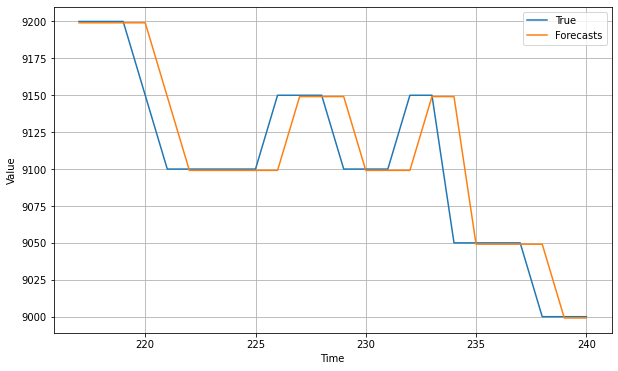

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="True")
plot_series(time_valid, rnn_forecast, label="Forecasts")
plt.legend()

## Check Performance on Both Training and Testing

In [12]:
rnn_forecast = model_forecast(model, series[:, np.newaxis], batch_size, window_size)
rnn_forecast = rnn_forecast[:split_time - window_size, -1, 0]

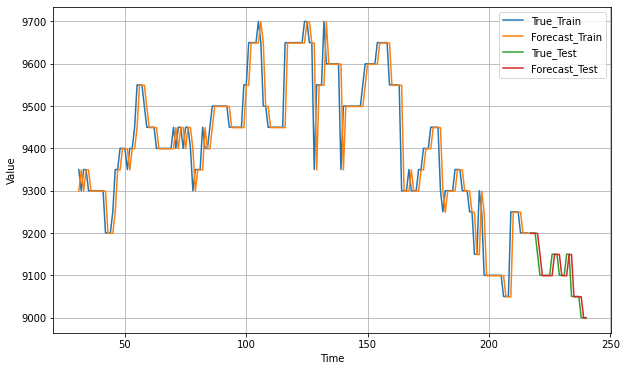

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_train[window_size:], x_train[window_size:], label="True_Train")
plot_series(time_train[window_size:], rnn_forecast[:], label="Forecast_Train")

rnn_forecast_2 = model_forecast(model, series[:, np.newaxis], batch_size, window_size)
rnn_forecast_2 = rnn_forecast_2[split_time - window_size:-1, -1, 0]

plot_series(time_valid, x_valid, label="True_Test")
plot_series(time_valid, rnn_forecast_2, label="Forecast_Test")

plt.legend()

In [14]:
#Mape Metrics
print("MAPE on tests:",tf.keras.metrics.mean_absolute_percentage_error(x_valid, rnn_forecast_2).numpy())
print("MAPE on train:",tf.keras.metrics.mean_absolute_percentage_error(x_train[window_size:], rnn_forecast).numpy())
print("MSE on tests:",tf.keras.metrics.mean_squared_error(x_valid, rnn_forecast_2).numpy())
print("MSE on train:",tf.keras.metrics.mean_squared_error(x_train[window_size:], rnn_forecast).numpy())

MAPE on tests: 0.18894033
MAPE on train: 0.32077223
MSE on tests: 1027.5653
MSE on train: 3655.3313


# Proceed to All Region and Forecast

In [19]:
output_data = pd.DataFrame(columns = ["Tanggal"])
time = dataset["Tanggal"].values[-1]
for i in range(NUM_FORECASTS):
  time += np.timedelta64(1,'D')
  output_data = output_data.append({"Tanggal":time},
                                   ignore_index=True)

In [20]:
columns = ['SEMUA PROVINSI', 'JAWA TIMUR', 'Kota Blitar', 'Kota Kediri',
           'Kota Madiun', 'Kota Malang', 'Kota Probolinggo', 'Kota Surabaya',
           'Kab. Banyuwangi', 'Kab. Jember', 'Kab. Sumenep']
col = pd.Series(columns)
for i in tqdm(col):
  #Preparing Data
  x_train = dataset[i].values
  
  #Build Model
  tf.keras.backend.clear_session()
  tf.random.set_seed(SEED)
  np.random.seed(SEED)

  train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

  model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(64, activation="relu", input_shape = [None, 1]),
      tf.keras.layers.Dense(32, activation="relu"),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(1)
      ])
  
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)

  model.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(),
                  optimizer=optimizer,
                  metrics=["mse", "mae"])
  history = model.fit(train_set, epochs=100, verbose=0)

  #Forecasting
  pre = []
  data_temp = x_train.copy()
  for j in range(NUM_FORECASTS):
    rnn_forecast = model_forecast(model, data_temp[-window_size:, np.newaxis], 8, window_size)
    rnn_forecast = rnn_forecast[:, -1, 0]      
    pre.append(round(rnn_forecast[0]))
  output_data[i] = pre

100%|██████████| 11/11 [02:32<00:00, 13.82s/it]


In [26]:
output_data.to_csv("predict_beras_jatim.csv", index=False)